In [1]:
# Import Library
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Dataset training
train = pd.read_csv('dataset\dummy_data raw\goemotions_1.csv')
train = pd.read_csv('dataset\dummy_data raw\goemotions_2.csv')
train = pd.read_csv('dataset\dummy_data raw\goemotions_3.csv')
train.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.describe()

,created_utc,rater_id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,4.000000e+00,4.000000,4.0,4.0,4.0,4.0,4.00,4.0,4.00,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
mean,1.547432e+09,47.250000,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,7.796815e+05,22.020823,0.0,0.0,0.0,0.0,0.50,0.0,0.50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.546328e+09,24.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.547180e+09,37.500000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.547656e+09,44.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.547908e+09,53.750000,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.548088e+09,77.000000,0.0,0.0,0.0,0.0,1.00,0.0,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


55.0 38.13135192987524 15 91


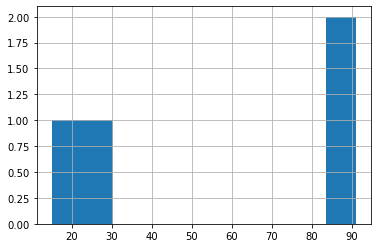

In [4]:
# Panjang dari komentar
lens = train.text.str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

lens.hist();

In [5]:
train.shape[0] #rows

4

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = str(train.text.values)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black'
).generate(text)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [11]:
import re, string

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    # string which is not needed but appears frequently
    no_need = ['@', 'yang', 'dan', 'di', 'karena', 'untuk', 'juga', 'tahun', 'dr', 'atau', 'prabowo', 'jokowi']
    
    words = re_tok.sub(r' \1 ', s).split()
    return [x for x in words if not x in no_need]

In [12]:
tokenize(train.text[0])

['Worst',
 'ending',
 'ever',
 '!',
 'I',
 'won',
 "'",
 't',
 'spoil',
 'it',
 'but',
 'this',
 'one',
 'sucked',
 'worse',
 'than',
 'the',
 'avengers',
 'last',
 'movie',
 '!']

In [13]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=2, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

trn_term_doc = vec.fit_transform(train['text'])

# Use the same dataset to test
test = train
test_term_doc = vec.transform(test['text'])

In [14]:
trn_term_doc
test_term_doc

<4x3 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [15]:
df_term_doc = pd.DataFrame(trn_term_doc.toarray())
df_term_doc

,0,1,2
0,0.767495,0.453295,0.453295
1,1.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000
3,0.000000,1.000000,0.000000


In [16]:
# Basic naive bayes feature equation
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [17]:
x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [18]:
labels = ['anger', 'ending', 'ever', 'sadness', 'disgust', 'neutral', 'anticipation', 'joy']

preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(labels):
   print('fit', j)
   m,r = get_mdl(train[j])
   preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]


fit anger


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [19]:
result = pd.concat([test["text"], pd.DataFrame(preds, columns = labels)], axis=1)
result

,text,anger,ending,ever,sadness,disgust,neutral,anticipation,joy
0,Worst ending ever! I won't spoil it but this o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Happy cake day u/sneakpeekbot!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Was he rejected because of his methodology or ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"thanks, I agree",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Simpan hasil yang ada pada CSV
result.to_csv('result.csv', index=False)

In [21]:
def predict_labels(text):
    for i, j in enumerate(labels):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

IndentationError: expected an indented block (<ipython-input-21-28d11fab1f0b>, line 3)

In [22]:
test_x

<4x3 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>